<center><h1> Initial process of cleaning lending club data. </h1></center>

### We begin with a very large feature space with a large number of empty features. In this notebook we will begin the cleaning process to reduce those features to a more manageable amount before attempting to build a model.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

### Reading in data files.
For this project 6 quarterly files, 3 from the pre-IPO period and 3 from the post-IPO period, will be used and were downloaded from the following source: <br><br>
https://www.lendingclub.com/info/download-data.action

The quarters used in this project include:
- 2014: Q1, Q2, Q3
- 2016: Q3, Q4
- 2017: Q1
<br><br>

2014 data is only available for download as the entire year. The first 3 quarters of 2014 were removed from that file and written to individual CSVs representative of each quarter.


In [2]:
#Using glob to read in and concatenate all quarterly files.
path = r"C:\Users\AH\Documents\Education\M.S. Analytics\Fall\DATA 900\LendingClubAssignment\Data"

allFiles = [g for g in glob.glob(os.path.join(path, "*.csv"))]
LoanData = pd.DataFrame()


for file_ in allFiles:
    current = pd.read_csv(file_)
    LoanData = pd.concat([LoanData,current], axis=0, ignore_index=True)

C:\Users\AH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\AH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\AH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\AH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Initial shape of all files concatenated.
print(LoanData.shape)

LoanData.isnull().sum().sum()

(460942, 145)


21697380

In [5]:
#Dropping all columns that have completely missing data.
LoanData = LoanData.dropna(axis=1, how='all')
print('Data shape after dropping completely empty columns:', LoanData.shape)

#Dropping columns that have less than 400000 filled rows.
LoanData = LoanData.dropna(thresh=400000, axis=1)
print('Data shape after dropping columns that do not have at least 400k complete rows:', LoanData.shape)

Data shape after dropping completely empty columns: (460942, 87)
Data shape after dropping columns that do not have at least 400k complete rows: (460942, 87)


In [6]:
#Examining number of loans issued for each time period.
LoanData['issue_d'].value_counts()

Mar-17      37181
Aug-16      36280
Dec-16      36183
Jul-16      34696
Nov-16      34591
Oct-16      32772
Jan-17      31835
Jul-2014    29306
Sep-16      28144
Feb-17      27763
May-2014    19099
Apr-2014    19071
Aug-2014    18814
Jun-2014    17179
Mar-2014    16513
Jan-2014    15628
Feb-2014    15269
Sep-2014    10606
Name: issue_d, dtype: int64

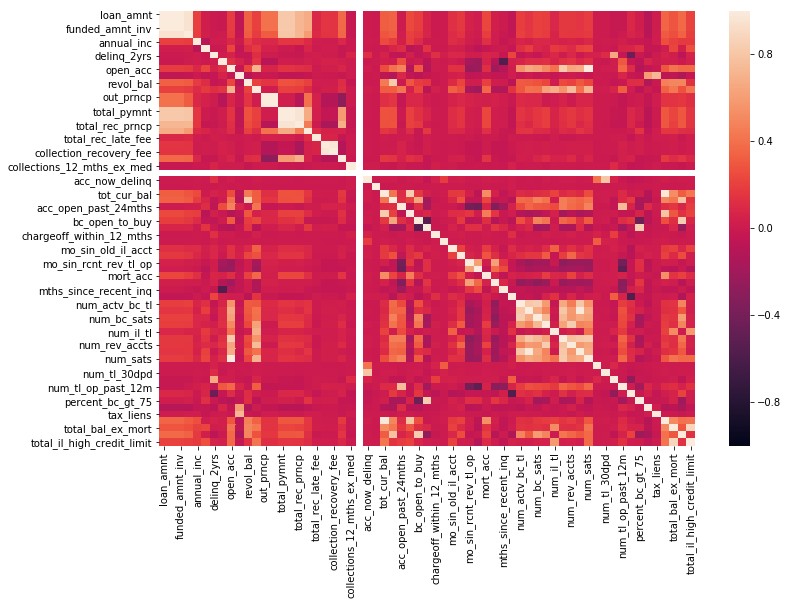

In [7]:
#Beginning to examine correlation amongst columns.
%matplotlib inline

plt.figure(figsize = (12,8))
sns.heatmap(LoanData.corr(), vmin=-1, vmax=1)

In [16]:
#Creating correlation matrix of features.
corr = LoanData.corr()
corr.style.background_gradient()

C:\Users\AH\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


## Data Cleaning.

In [8]:
#Creating new grade column which groups loan into either group AB or others.
gradelist = []

for grade in LoanData['grade']:
    if grade =="A" or grade == "B":
        gradelist.append('AB')
    else:
        gradelist.append('Other')
        
LoanData['NewGrade'] = gradelist

#Showing frequency of different classes, AB or other. Through this we see that classes are not imbalanced.
LoanData.groupby(['NewGrade'])['NewGrade'].value_counts()

#Through the creation of this NewGrade column, the original grade is kept for further analysis later on in the project.
#'grade' will be removed for modeling and prediction purposes.

NewGrade  NewGrade
AB        AB          198217
Other     Other       262725
Name: NewGrade, dtype: int64

In [11]:
#List of columns to be removed that are highly correlated with loan_amount.
#These will need to be dropped.
loancorrlist = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int']


#List of columns that should be dropped for other purposes.
#Reasons for dropping these columns include redundancy, irrelevance to problem, etc. Decided through own research.
#Several of these columns also represent data recorded after loan was approved, which will not serve the project's purpose.

droplist = ['policy_code', 'int_rate', 'sub_grade', 'pymnt_plan', 'initial_list_status', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
           'loan_status', 'title', 'zip_code', 'earliest_cr_line', 'out_prncp_inv', 'total_rec_late_fee',
           'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 'disbursement_method', 'hardship_flag',
           'debt_settlement_flag', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts',
           'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'revol_bal', 'tot_hi_cred_lim', 'total_acc',
           'total_bal_ex_mort', 'total_il_high_credit_limit', 'emp_title']

#Dropping these columns from the dataset.
LoanData = LoanData.drop(loancorrlist, axis=1)
LoanData = LoanData.drop(droplist, axis=1)

print(LoanData.shape)

(460942, 43)


##### We are now left with 43 columns, however there are several columns which still contain a large amount of missing data.

3 columns with more than 10,000 missing values.
- emp_length
- mo_sin_old_il_acct
- mths_since_recent_inq

In [12]:
LoanData.isna().sum() > 10000

term                          False
grade                         False
emp_length                     True
home_ownership                False
annual_inc                    False
verification_status           False
issue_d                       False
purpose                       False
addr_state                    False
dti                           False
delinq_2yrs                   False
inq_last_6mths                False
open_acc                      False
pub_rec                       False
revol_util                    False
collections_12_mths_ex_med    False
application_type              False
acc_now_delinq                False
tot_cur_bal                   False
total_rev_hi_lim              False
acc_open_past_24mths          False
avg_cur_bal                   False
bc_open_to_buy                False
bc_util                       False
chargeoff_within_12_mths      False
delinq_amnt                   False
mo_sin_old_il_acct             True
mo_sin_old_rev_tl_op        

In [13]:
#In order to minimize data lost, we drop these columns.
LoanData = LoanData.drop(['emp_length', 'mo_sin_old_il_acct', 'mths_since_recent_inq'], axis = 1)

print(LoanData.shape)

(460942, 40)


### Cleaning remaining columns for modeling purposes.

In [14]:
#Number of rows of data which will be removed in the current state of the x-feature space.
print("This number of rows will be removed from the feature space at this point:",
      LoanData.shape[0] - LoanData.dropna().shape[0])

#Removing rows.
LoanData = LoanData.dropna()
print("Current shape of feature space after removing rows:", LoanData.shape)

This number of rows will be removed from the feature space at this point: 5386
Current shape of feature space after removing rows: (455556, 40)


In [15]:
#Removing percent sign from revol_util and changing data type to numeric.
LoanData['revol_util'] = LoanData['revol_util'].str.replace('%', '')
LoanData['revol_util'] = pd.to_numeric(LoanData['revol_util'])

In [16]:
#Changing verification status to not verified vs verified.
LoanData['verification_status'] = LoanData['verification_status'].str.replace('Source Verified', 'Verified')

LoanData['verification_status'].value_counts()

Verified        323797
Not Verified    131759
Name: verification_status, dtype: int64

In [18]:
#Removal of joint loan applications.
LoanData = LoanData[LoanData.application_type != 'Joint App']

#Dropping application type column after doing this as all values are now the same.
LoanData = LoanData.drop('application_type', axis = 1)

print(LoanData.shape)

(446725, 39)


In [19]:
print("List of columns:")
print(list(LoanData.columns))
print('\n')
print("Shape of cleaned dataframe to be used in modeling process:", LoanData.shape)
LoanData.head()

List of columns:
['term', 'grade', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_il_tl', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'total_bc_limit', 'NewGrade']


Shape of cleaned dataframe to be used in modeling process: (446725, 39)


,term,grade,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,collections_12_mths_ex_med,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_rev_tl,num_il_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit,NewGrade
0,60 months,C,RENT,86400.0,Not Verified,Mar-2014,debt_consolidation,NV,21.53,0.0,0.0,12.0,0.0,45.1,0.0,0.0,91651.0,52300.0,3.0,8332.0,26443.0,45.5,0.0,0.0,195.0,19.0,14.0,0.0,0.0,7.0,5.0,0.0,0.0,100.0,71.4,0.0,0.0,48500.0,Other
1,36 months,B,MORTGAGE,100000.0,Not Verified,Mar-2014,debt_consolidation,WI,29.88,0.0,0.0,36.0,0.0,47.2,0.0,0.0,246496.0,125800.0,6.0,7043.0,26232.0,60.9,0.0,0.0,183.0,8.0,8.0,2.0,0.0,13.0,6.0,0.0,3.0,100.0,53.3,0.0,0.0,67100.0,AB
2,60 months,G,RENT,60000.0,Verified,Mar-2014,moving,CA,20.78,0.0,3.0,11.0,1.0,22.8,0.0,0.0,22109.0,9100.0,7.0,2010.0,3335.0,32.2,0.0,0.0,208.0,1.0,1.0,0.0,0.0,7.0,17.0,0.0,3.0,100.0,0.0,1.0,0.0,5300.0,Other
3,60 months,B,MORTGAGE,145000.0,Verified,Mar-2014,debt_consolidation,VA,9.36,0.0,2.0,10.0,0.0,32.7,0.0,0.0,437678.0,29700.0,5.0,48631.0,12366.0,41.7,0.0,0.0,271.0,4.0,4.0,2.0,0.0,4.0,6.0,0.0,4.0,95.5,33.3,0.0,0.0,21200.0,AB
4,60 months,D,RENT,36000.0,Verified,Mar-2014,debt_consolidation,NJ,12.60,2.0,0.0,18.0,0.0,59.8,0.0,0.0,10136.0,16700.0,3.0,780.0,348.0,91.3,0.0,0.0,123.0,4.0,4.0,0.0,1.0,8.0,2.0,0.0,2.0,70.0,100.0,0.0,0.0,4000.0,Other


In [53]:
#Writing feature space that will be used to build model to a csv.
# LoanData.to_csv("CleanLoan.csv", index=False)

## Additional Analysis after modeling.

In [54]:
#Creating dataframe to be written to csv file for further analysis.
#This file will be used to assist with further analysis of several aspects of where the models had trouble with predictions.
GradeFrame = LoanData[['grade', 'addr_state', 'issue_d', 'NewGrade']]

#Writing to CSV.
# GradeFrame.to_csv("GradeLoans.csv", index=False)
GradeFrame.head()

,grade,addr_state,issue_d,NewGrade
0,C,NV,Mar-2014,Other
1,B,WI,Mar-2014,AB
2,G,CA,Mar-2014,Other
3,B,VA,Mar-2014,AB
4,D,NJ,Mar-2014,Other
